In [1]:
# STEP 0
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten
from tensorflow.keras.constraints import unit_norm
import matplotlib.pyplot as plt

In [2]:
# STEP 1
x = np.load('images.npy')
y = np.load('labels.npy')

x = np.true_divide(x, 255)

unique, counts = np.unique(y, return_counts=True)
print("number of images each class: ",dict(zip(unique, counts)))

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1)

print("data training: ", x_train.shape, y_train.shape)
print("data validation: ", x_val.shape, y_val.shape)
print("data testing: ", x_test.shape, y_test.shape)

number of images each class:  {0: 25, 1: 100}
data training:  (100, 128, 128, 3) (100,)
data validation:  (12, 128, 128, 3) (12,)
data testing:  (13, 128, 128, 3) (13,)


In [3]:
# STEP 2
def build_model():
    model = Sequential()
    model.add(Conv2D(16, (3, 3), padding="same", input_shape=(128,128,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Conv2D(32, (3, 3), padding="same"))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(96, (2, 2), padding="same"))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
      
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu', kernel_constraint=unit_norm()))
    model.add(Dense(256, activation='relu', kernel_constraint=unit_norm()))
    
    model.add(Dense(2, activation='softmax', kernel_constraint=unit_norm()))
    
    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, 
                                 epsilon=None, decay=0.0, amsgrad=False), 
                  metrics=['accuracy'])
    
    return model

In [4]:
# STEP 3
model = build_model()
model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=32, epochs=10)

Epoch 1/10
4/4 [==============================] - 2s 222ms/step - loss: 0.5623 - accuracy: 0.7600 - val_loss: 0.2495 - val_accuracy: 0.9167
Epoch 2/10
4/4 [==============================] - 1s 176ms/step - loss: 0.5219 - accuracy: 0.7800 - val_loss: 0.4335 - val_accuracy: 0.9167
Epoch 3/10
4/4 [==============================] - 1s 177ms/step - loss: 0.5359 - accuracy: 0.7800 - val_loss: 0.3708 - val_accuracy: 0.9167
Epoch 4/10
4/4 [==============================] - 1s 170ms/step - loss: 0.5134 - accuracy: 0.7800 - val_loss: 0.2636 - val_accuracy: 0.9167
Epoch 5/10
4/4 [==============================] - 1s 173ms/step - loss: 0.4688 - accuracy: 0.7800 - val_loss: 0.3762 - val_accuracy: 0.9167
Epoch 6/10
4/4 [==============================] - 1s 179ms/step - loss: 0.5019 - accuracy: 0.7800 - val_loss: 0.4196 - val_accuracy: 0.9167
Epoch 7/10
4/4 [==============================] - 1s 172ms/step - loss: 0.4955 - accuracy: 0.7800 - val_loss: 0.2587 - val_accuracy: 0.9167
Epoch 8/10
4/4 [====

In [5]:
# STEP 4
print("\n\nUSING ARGMAX:")

y_pred_val = model.predict(x_val)
y_pred_val_argmax = y_pred_val.argmax(axis=-1)
conf_mat_val = confusion_matrix(y_val, y_pred_val_argmax)

print("\nvalidation confusion matrix:\n",conf_mat_val)
print("\nvalidation F1 score:", f1_score(y_val, y_pred_val_argmax, pos_label=0))



USING ARGMAX:

validation confusion matrix:
 [[ 0  1]
 [ 0 11]]

validation F1 score: 0.0


In [6]:
# STEP 5
thresholds = np.arange(0.1,1,0.1)
f1_val = []

y_pred_val = model.predict(x_val)

for th in thresholds:
    y_pred_val_th = [1 if y_p<th else 0 for y_p in y_pred_val[:,0]]
    f1_val.append(f1_score(y_val,y_pred_val_th, pos_label=0))



USING THRESHOLD WITH BEST F1 SCORE:

Best validation F1= 1.0 with threshold= 0.30000000000000004


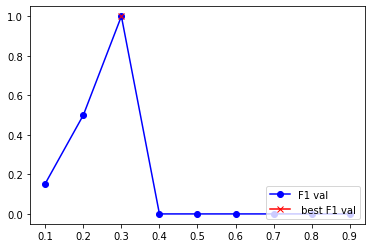

In [7]:
# STEP 6
idx_best = np.argmax(f1_val)

plt.plot(thresholds, f1_val, marker='o', color='blue', label='F1 val')
plt.plot(thresholds[idx_best], f1_val[idx_best], marker='x', color='red', label=' best F1 val')
plt.legend(loc='lower right')

print("\n\nUSING THRESHOLD WITH BEST F1 SCORE:")
print("\nBest validation F1=", f1_val[idx_best], "with threshold=", thresholds[idx_best])

plt.show()

In [8]:
# STEP 7
y_pred_test = model.predict(x_test)

y_pred_test_argmax = y_pred_test.argmax(axis=-1)
print("\nF1 score of the testing data with argmax =", f1_score(y_test, y_pred_test_argmax, pos_label=0))

y_pred_test_threshold = [1 if y_p<thresholds[idx_best] else 0 for y_p in y_pred_test[:,0]]
print("\nF1 score of the testing data with threshold =", f1_score(y_test, y_pred_test_threshold, pos_label=0))


F1 score of the testing data with argmax = 0.0

F1 score of the testing data with threshold = 1.0
